In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import tqdm
import scienceplots
plt.style.use('science')

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_FaIRGP as fairgp
import fit_Plain_GP as plaingp
from src.preprocessing.glob import load_emissions_dataset, load_response_dataset
from src.structures import Scenario, ScenarioDataset
from src.fair import run, get_params
from notebooks import utils
from notebooks.xgrid_utils import calc_spatial_integral, _quadrant_area, _guess_bounds

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

fairgpmodel = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/all-ssps/FaIRGP/state_dict.pt')
fairgpmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
input_hist_aer = load_emissions_dataset('../data/inputs_hist-aer.nc')
output_hist_aer = load_response_dataset('../data/outputs_hist-aer.nc')

In [5]:
xr_input = input_hist_aer
xr_output = output_hist_aer
weights = np.cos(np.deg2rad(xr_input.latitude))

# Extract time steps array
time = xr_input.time.values

# Extract cumulative emissions
cum_CO2_emissions = xr_input.CO2.values
cum_emissions = cum_CO2_emissions

# Compute emissions
CO2_emissions = np.append(cum_CO2_emissions[0], np.diff(cum_CO2_emissions))
CH4_emissions = xr_input.CH4.values
SO2_emissions = calc_spatial_integral(xr_input.SO2).data
BC_emissions = calc_spatial_integral(xr_input.BC).data
emissions = np.stack([CO2_emissions, CH4_emissions, SO2_emissions, BC_emissions])

# Compute average temperature anomaly
weights = np.cos(np.deg2rad(xr_output.lat))
tas = xr_output.tas.weighted(weights).mean(['lat', 'lon', 'member']).data

# Create scenario
hist_aer = Scenario(name='hist-aer',
                    timesteps=torch.from_numpy(time).float(),
                    emissions=torch.from_numpy(emissions).float().T,
                    tas=torch.from_numpy(tas).float())

In [7]:
base_kwargs = utils.get_fair_params()
fairgpmodel = fairgpmodel.eval()
test_scenarios = ScenarioDataset([hist_aer], None)
res = run(time=hist_aer.timesteps.numpy(),
          emission=hist_aer.emissions.T.numpy(),
          base_kwargs=base_kwargs,
          use_aci=True)
test_tas_fair = res['T']

In [8]:
with torch.no_grad():
    farigp_posterior = fairgpmodel(test_scenarios)
    noisy_fairgp_posterior = fairgpmodel.likelihood(farigp_posterior)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:25: UserWarning: gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense
  warnings.warn("gpytorch.lazy.delazify is deprecated in favor of linear_operator.to_dense")


In [9]:
fairgp_posterior_mean = farigp_posterior.mean + test_tas_fair
fairgp_posterior_lb, fairgp_posterior_ub = farigp_posterior.confidence_region()
fairgp_posterior_lb = fairgp_posterior_lb.detach() + test_tas_fair
fairgp_posterior_ub = fairgp_posterior_ub.detach() + test_tas_fair

noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub = noisy_fairgp_posterior.confidence_region()
noisy_fairgp_posterior_lb = noisy_fairgp_posterior_lb.detach() + test_tas_fair
noisy_fairgp_posterior_ub = noisy_fairgp_posterior_ub.detach() + test_tas_fair

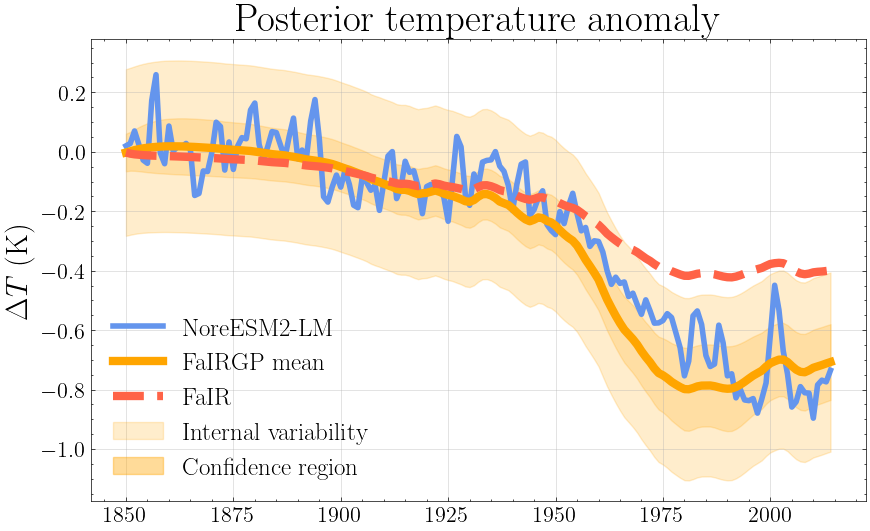

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(hist_aer.timesteps, hist_aer.tas, lw=4, color='cornflowerblue', label='NoreESM2-LM')
ax.plot(hist_aer.timesteps, fairgp_posterior_mean, color='orange', lw=6, label='FaIRGP mean')
ax.plot(hist_aer.timesteps, test_tas_fair, color='tomato', ls='--', lw=6, label='FaIR')
ax.fill_between(hist_aer.timesteps, fairgp_posterior_lb, fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Internal variability')
ax.fill_between(hist_aer.timesteps, noisy_fairgp_posterior_lb, noisy_fairgp_posterior_ub, alpha=0.2, color='orange',
                   label='Confidence region')
ax.tick_params(labelsize=16)
ax.set_ylabel(r'$\Delta T$ (K)', fontsize=22)
ax.grid(alpha=0.5)
ax.set_title(r'Posterior temperature anomaly', fontsize=28)

legend = ax.legend(loc='lower left', fontsize=18)
legend.legendHandles[4].set_alpha(0.4)

plt.savefig('./figures/hist-aer-global-prediction-paper-plot.jpg', dpi=200)